In [185]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import csv
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.notebook_repr_html', True)

def _repr_latex_(self):
    return "\\begin{center} %s \\end{center}" % self.to_latex()

pd.DataFrame._repr_latex_ = _repr_latex_  # monkey patch pandas DataFrame


with open('processed.csv', 'rb') as f:
    reader = csv.reader(f)
    first = True
    columns = []
    values = []
    dates = []
    for row in reader:
        if first:
            first = False
            columns = row[1:-3] + [row[-3]]
        else:
            dates.append(datetime.datetime.strptime(row[0], '%Y/%m/%d'))
            values.append(map(lambda x: float(x) or np.nan, row[1:-3] + [row[-3]]))

df = pd.DataFrame(values, index=dates, columns=columns).sort_index()    
df_ = pd.DataFrame(values, index=dates, columns=columns).sort_index()
companies = list(columns)
freqs = [3, 7, 15, 30]
for col in df_:
    if col in ('Day',):
        continue
    
    c = df_[col]
    cs = df_[col].shift(1)
    inc_col = '%s_Direction' % col
    df_[inc_col] = np.sign(df_[col] - df_[col].shift(1))
    df_[inc_col].fillna(inplace=True, value=0)
    df_['%s_Lag_%d' % (inc_col, 1)] = df_[inc_col].shift(1)
    for freq in freqs:
        rm_col = '%s_RollM_%d' % (col, freq)
        rstd_col = '%s_RollStd_%d' % (col, freq)
        rmax_col = '%s_RollMax_%d' % (col, freq)
        rmin_col = '%s_RollMin_%d' % (col, freq)
        rvar_col = '%s_RollVar_%d' % (col, freq)
        rsum_col = '%s_RollSum_%d' % (col, freq)
        pchange_col = '%s_PChange_%d' % (col, freq)
        ewma_col = '%s_EWMA_%d' % (col, freq)
        mp = freq < 10 and freq or 10

        df_[pchange_col] = df_[col].pct_change(periods=freq)
        df_[rsum_col] = pd.rolling_sum(cs, freq, min_periods=mp)
        df_[rvar_col] = pd.rolling_var(cs, freq, min_periods=mp)
        df_[rmin_col] = pd.rolling_min(cs, freq, min_periods=mp)
        df_[rmax_col] = pd.rolling_max(cs, freq, min_periods=mp)
        df_[rstd_col] = pd.rolling_std(cs, freq, min_periods=mp)
        df_[rm_col] = pd.rolling_mean(cs, freq, min_periods=mp)
        df_[ewma_col] = pd.ewma(cs, span=freq)
    for i in xrange(1, 30, 5):
        df_['%s_Lag%d' % (col, i)] = df_[col].shift(i)


In [186]:
def get_independent_values(symbol, df=df_):
    return filter(lambda x: x.startswith(symbol + '_') or x == symbol, df_.columns)

def prepare_df(df, input_cols, output_col, drop_cols=[]):
    import pandas as pd
    df = df_[list(set(list(input_cols) + [output_col]))].dropna()
    
    X = df.drop([output_col] + list(drop_cols), axis=1)
    y = df[output_col]
    return X, y
               
def split_for_train(X, y, sd, ed):
    start_test = ed - (ed - sd) / 2
    X_train = X[X.index < start_test]
    X_test = X[X.index >= start_test]
    y_train = y[y.index < start_test]
    y_test = y[y.index >= start_test]  
    return X_train, y_train, X_test, y_test
    

def try_models(X_train, y_train, X_test, y_test, fs=None, draw=True):
    import pandas as pd
    import sklearn
    import itertools
    from sklearn.grid_search import GridSearchCV
    from sklearn.qda import QDA
    from sklearn.pipeline import Pipeline
    
    fs.fit(X_train, y_train)

    pred = pd.DataFrame({
            'Actual': y_test,
            'Predicted': fs.predict(X_test)
        }, index=y_test.index)
    
    pred['Variance'] = (pred["Actual"] - pred["Predicted"])
    pred['Error'] = pred['Variance'] ** 2

    res = {
        'Company': company,
        'FSEstimator': fs,
        'Mean Sq Err': np.mean(pred['Error']),
        'Std Err': np.std(pred['Actual']),
        'Score': fs.score(X_test, y_test),
        'Vars': (fs.get_params()),
    }

    res_df = pd.DataFrame(res, index=[0])
    if draw:
        d = pd.DataFrame(index=y_train.index.union(y_test.index))
        d['Actual'] = y_test.append(y_train)
        d['Predicted'] = pred['Predicted']
        d.plot(figsize=(20,5))
    return res_df

# Project
This project tries to create models for StockSplosion simulated market in order to assist analysts to make their buy/sell decisions easier.

## Cost
This project has been rated at *\$150/hr*.

- Web Client Development: \$1500
- Price Estimation Research: \$7500
- Total Cost: $9000

# Analysis
## Final Model
The dataset reacts in a specific way. Starting from Unix Epoch (1970-01-01), the price of any stock increases by 1.0 (+/- ~10% of the rolling average). There are no seasonalities or any other anomalies in the dataset. ~10% variation also appear to be random. In order to reduce the factor of randomness, the dataset has been resampled into 3 periods: 1 month, 1 quarter, and 1 year. As the length of a period increases, the pattern for the dataset becomes very apparent.

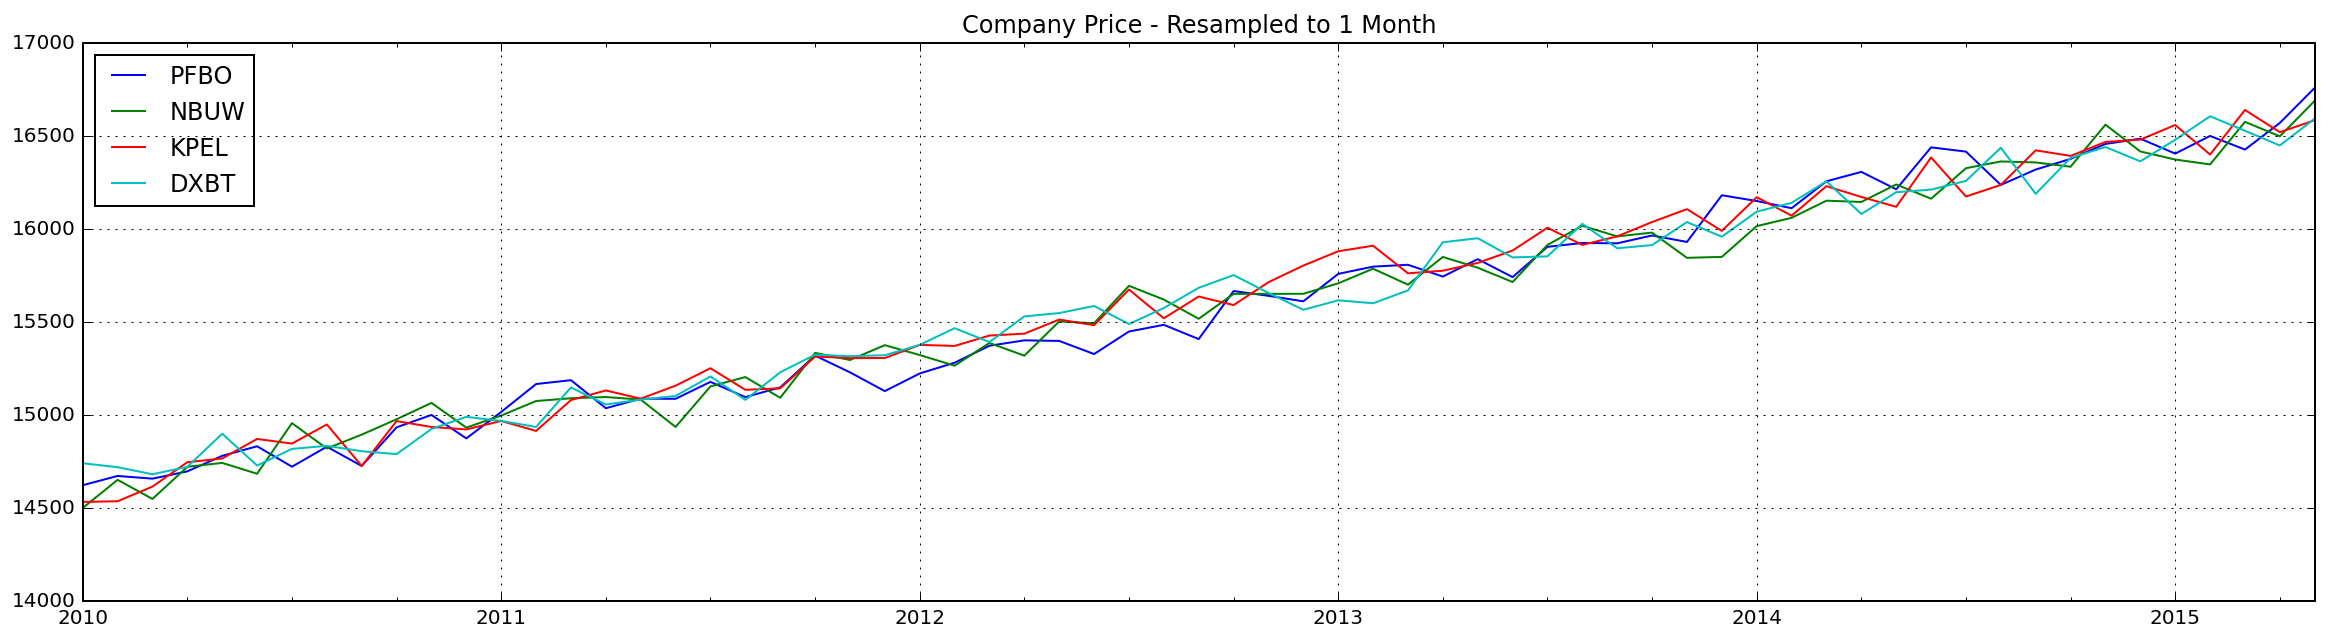

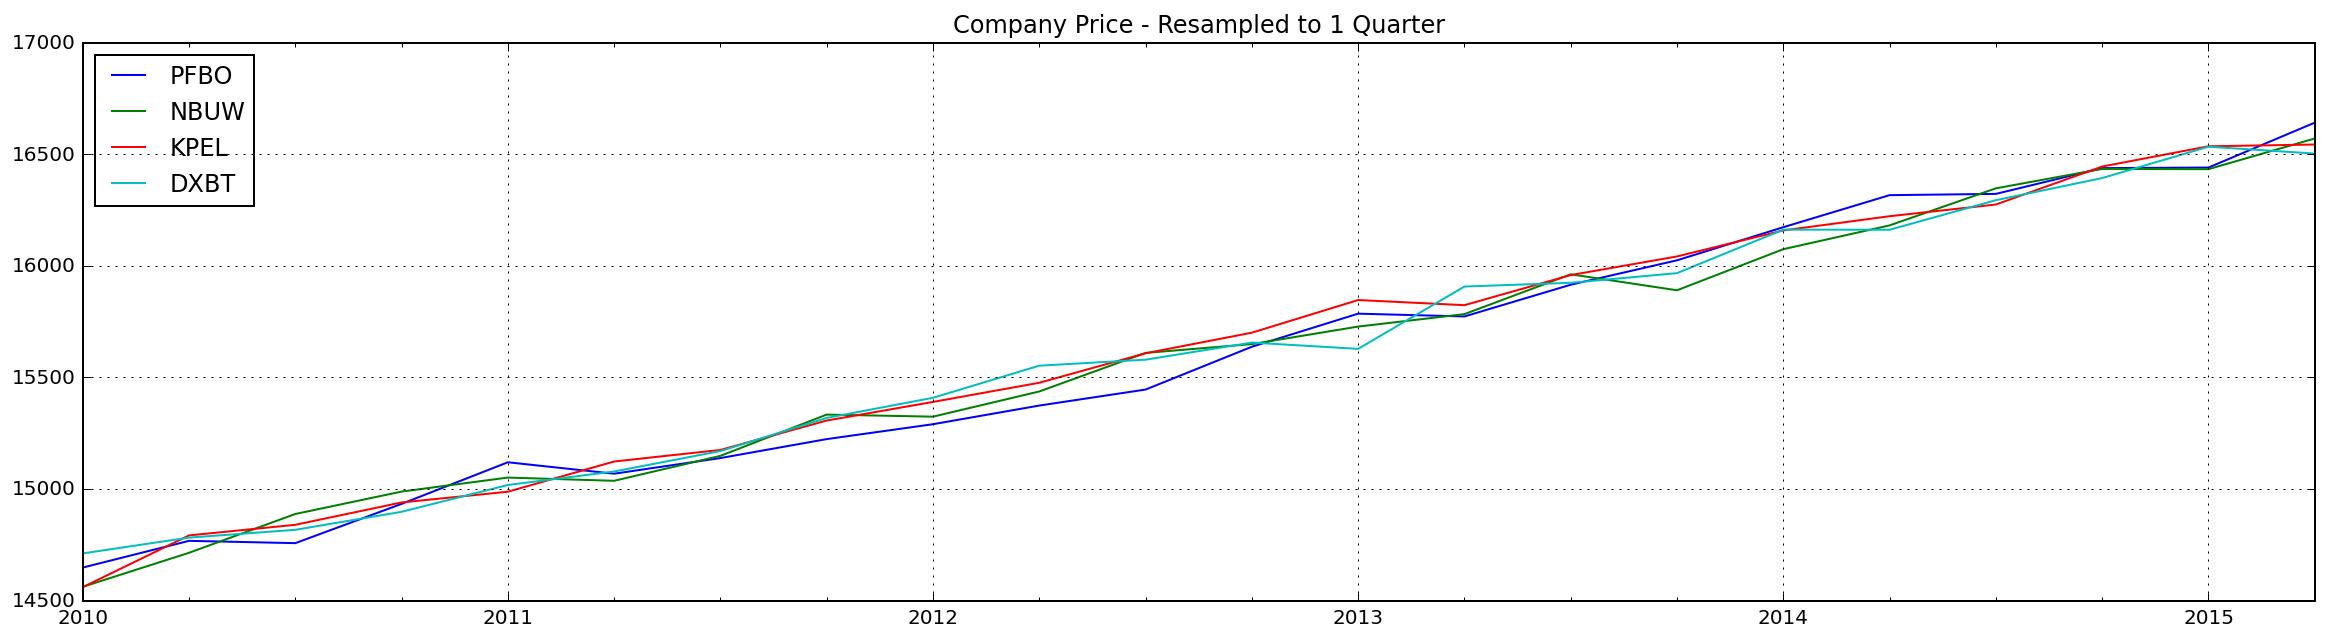

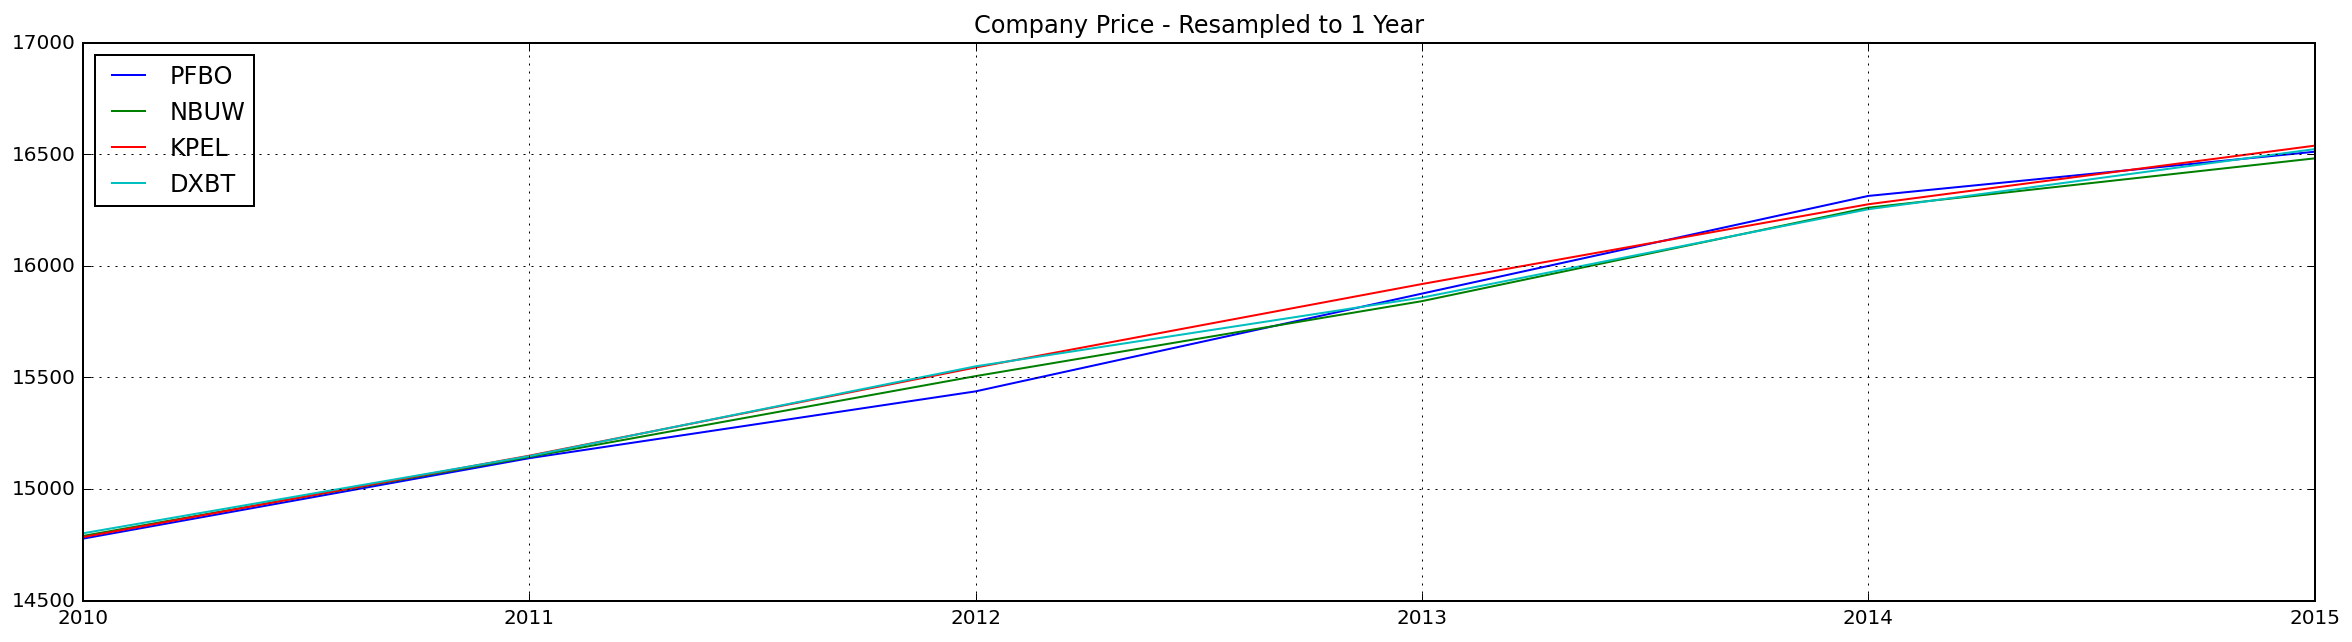

In [187]:
from datetime import datetime, timedelta
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.cross_validation import train_test_split as tts

epoch = datetime.utcfromtimestamp(0)
cc = {}
freq_names = {
    '1M': '1 Month',
    '1Q': '1 Quarter',
    '1A': '1 Year'
}
for freq in ('1M', '1Q', '1A'):
    periods = pd.Series(map(lambda x: x.days, np.array(df_.index.to_pydatetime()) - epoch))
    df = df_[['PFBO', 'NBUW', 'KPEL', 'DXBT']].resample(freq, how='mean')
    df.plot(figsize=(20,5), title='Company Price - Resampled to %s' % freq_names[freq])
pass

As it can be seen from the graphs above, the trend is always linearly upwards and there are no seasonality effects in place.

Since there are no seasonalities and the trend is always upwards linearly, the dataset fits perfectly for a *mean-reversion model*, that is the price will revert to its rolling mean over time. In real datasets, mean reversion may take a long time, thus it might not be attractive to investors. However in this dataset, the price fluctuates around and reverts to the mean all the time. Thus, we can calculate the trading range and the moving average price at any given time with very high accuracies using recent historical data.

After calculating the trading range and the moving average, we can use these to make suggestions to the analyst. If the current price is significantly higher than mean of last 30 days, it will fall in the following days, thus we suggest to *SELL*. If it is significantly lower than mean, it will rise soon, thus we suggest to *BUY*. However, if the price is close to mean, we suggest to *WAIT*.

## Research
Regardless of whether the data was simulated or not, it has been treated as if it is real market data and the research has been conducted accordingly.

### Data Preparion
#### Dataset Details 
The dataset covers the dates between `2010-01-01` and `2015-05-15` inclusive.

The dataset has been downloaded from the provided API using 10-day range per request. Although API allows 30-day range, any errors in API would result in a loss of 30-day data. Hence, 10-day turned out to be a meaningful range, it is fast enough to download and 10-day loss in 5.5 years of data is negligible and not likely affect the outcome.

#### Features Extracted
Total market value (sum of all prices for any given day) has been added to dataset.

The following values are added for each company (and total market value):

In [188]:
d = {
    'Rolling Mean': ['3-day, 7-day, 5-day, 30-day'],
    'Rolling Sum': ['3-day, 7-day, 5-day, 30-day'],
    'Rolling St. Dev': ['3-day, 7-day, 5-day, 30-day'],
    'Rolling Min': ['3-day, 7-day, 5-day, 30-day'],
    'Rolling Max': ['3-day, 7-day, 5-day, 30-day'],
    'Rolling Variance': ['3-day, 7-day, 5-day, 30-day'],
    'Percent Change': ['3-day, 7-day, 5-day, 30-day'],
    'EWMA': ['3-day, 7-day, 5-day, 30-day'],
    'Lagged Price': ['1-day, 2-day...15-day'],
    'Price Change': ['1-day, 2-day...15-day'],
    'Lagged Price Change Direction': ['1-day']
}
from IPython.display import display
display(pd.DataFrame(d, index=['Generated Range']).T)
pass

,Generated Range
EWMA,"3-day, 7-day, 5-day, 30-day"
Lagged Price,"1-day, 2-day...15-day"
Lagged Price Change Direction,1-day
Percent Change,"3-day, 7-day, 5-day, 30-day"
Price Change,"1-day, 2-day...15-day"
Rolling Max,"3-day, 7-day, 5-day, 30-day"
Rolling Mean,"3-day, 7-day, 5-day, 30-day"
Rolling Min,"3-day, 7-day, 5-day, 30-day"
Rolling St. Dev,"3-day, 7-day, 5-day, 30-day"
Rolling Sum,"3-day, 7-day, 5-day, 30-day"


The following graph from company *KPEL* visualises the price pattern. We can see the trading range, variation and the mean values of the price.

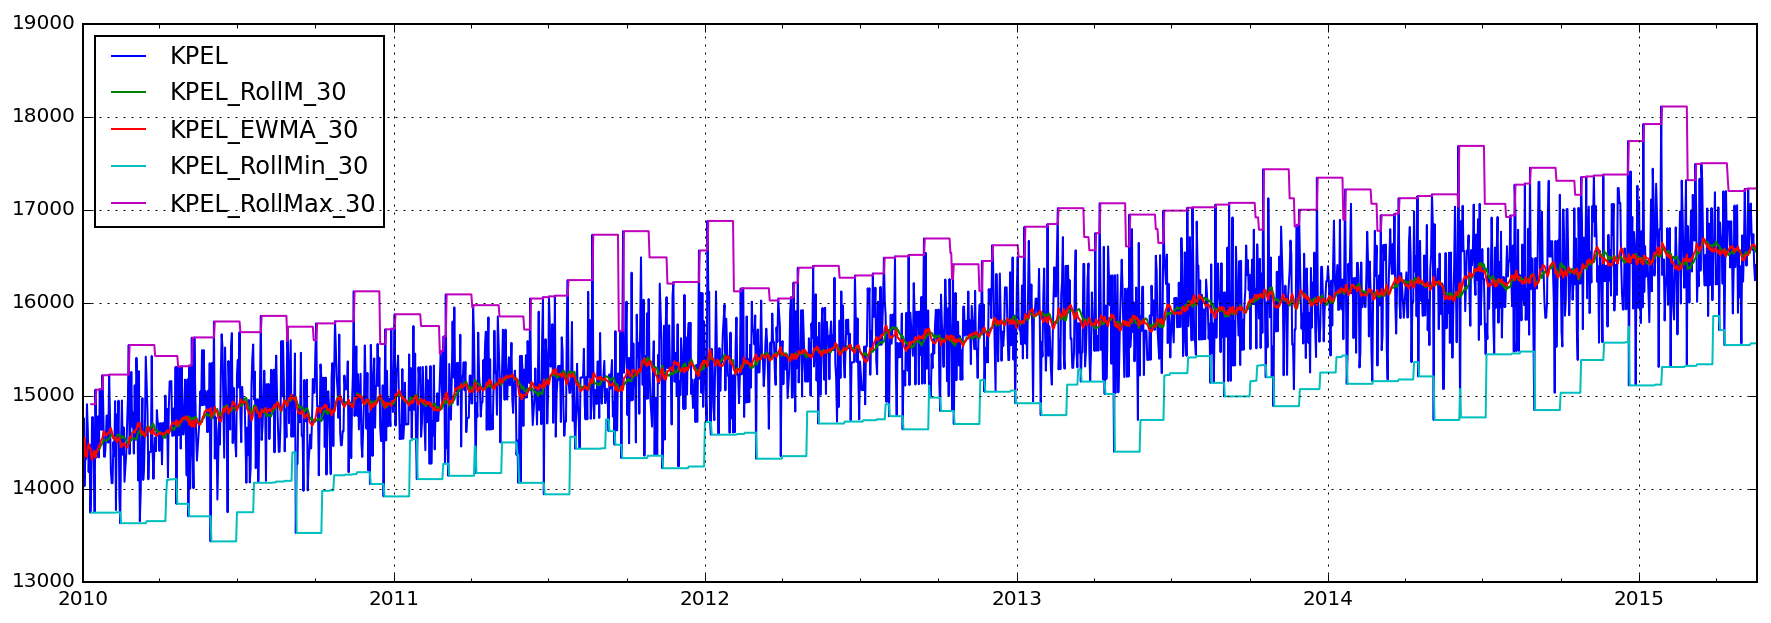

In [189]:
df_[get_independent_values('KPEL')].tail(3)
df_[['KPEL', 'KPEL_RollM_30', 'KPEL_EWMA_30', 'KPEL_RollMin_30', 'KPEL_RollMax_30']].plot(figsize=(15, 5))
pass

#### Train/Test Split
The dataset is split into two from the middle, this is because it's a time-series dataset and we haven't seen any seasonalities.

### Cluster Analysis
During cluster analysis, no meaningful clusters have been formed. Further research might be useful.

### Regression

#### Feature Selection
As a first filter to explore features and their effects on the prediction model, *SelectKBest*, *SelectPercentile* and *VarianceThreshold* models are used. This resulted that most important features are extracted features for the company and the total market. This supports previous findings on cluster analysis, no companies are acting together or affecting each other's behavior. 

As a second filter to reduce the number of features for a more generalized model, *RFECV* model has been used. *RFECV*, i.e. recursive feature elimination with cross-validation, removes `n` features in each loop and decides the optimum number of features using cross-validation. For this dataset, `n` was set to 1.

#### Price Direction Estimation
For price direction estimation `LogisticRegression` model is used. 

The model was able to predict with a score of `.724`.

The predicted directions were added to dataset for price estimation.

The features selected by *RFECV* are as follows:

In [190]:
display(pd.DataFrame({'Feature': ['Company Lag 1-day', 
                                  'Company EWMA 7-day',
                                  'Company Rolling Sum 15-day',
                                  'Company Rolling Mean 15-day']}, index=[1,2,3,4]))

,Feature
1,Company Lag 1-day
2,Company EWMA 7-day
3,Company Rolling Sum 15-day
4,Company Rolling Mean 15-day


The following graph shows the features chosen by *RFECV* (Rolling Sum feature has been omitted as it does not fit into this graph.)

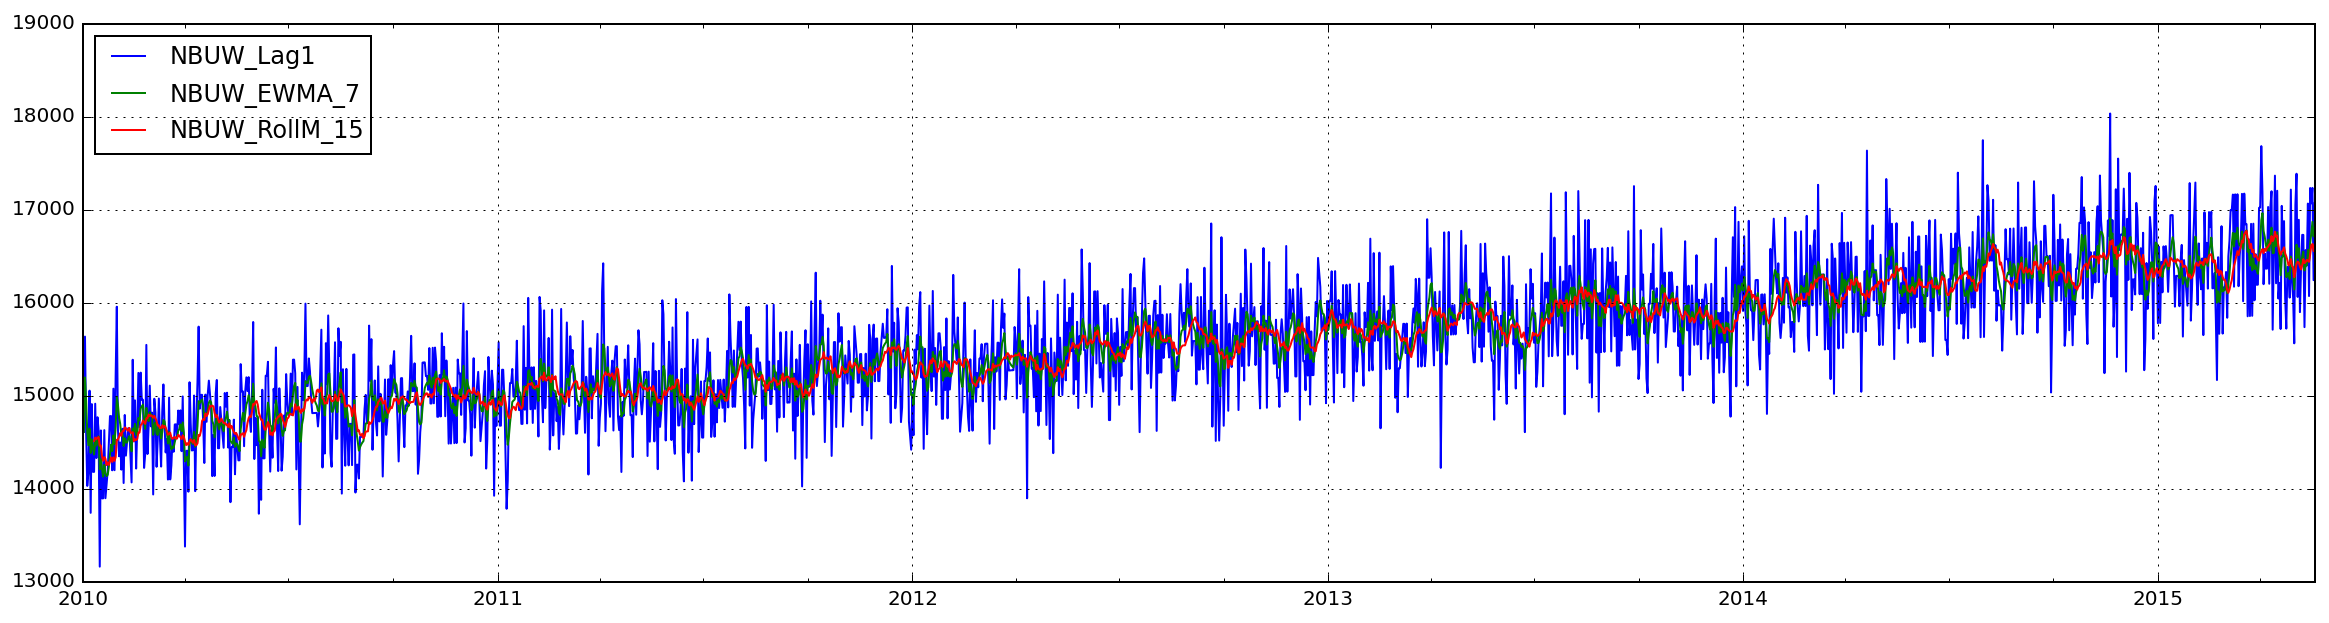

In [191]:
df_[['NBUW_Lag1', 'NBUW_EWMA_7', 'NBUW_RollM_15']].plot(figsize=(20, 5))
pass

#### Price Estimation
For price estimation, `LinearRegression`, `Ridge`, `RidgeCV` models are trained. Although the scores of models were pretty close, `Ridge` model with alpha `10` yielded more generalized results than the rest.

In [192]:
display(pd.DataFrame([{'Score': .528, 'Mean Sum of Square Errors': 154635., 'Actual Stdev': 572.6}], index=['NBUW']))
pass

,Actual Stdev,Mean Sum of Square Errors,Score
NBUW,572.6,154635,0.528


The features that yielded these results are as follows:

In [193]:
v = ['Company Percent Change 7-day',
'Company EWMA 7-day',
'Company EWMA 30-day',
'Total Percent Change 7-day',
'Total Rolling Sum 15-day',
'Total Rolling Variance 15-day',
'Total Percent Change 30-day',
'Total Rolling Sum 30-day',
'Total Lag 26',]
display(pd.DataFrame({'Feature': v}, index=range(1, len(v) + 1)))
pass

,Feature
1,Company Percent Change 7-day
2,Company EWMA 7-day
3,Company EWMA 30-day
4,Total Percent Change 7-day
5,Total Rolling Sum 15-day
6,Total Rolling Variance 15-day
7,Total Percent Change 30-day
8,Total Rolling Sum 30-day
9,Total Lag 26


In [194]:
# df_[['DXBT_PChange_7', 'Total_PChange_7', 'Total_PChange_30']].plot(figsize=(20, 5))
# df_[['DXBT_EWMA_7', 'DXBT_EWMA_30',]].plot(figsize=(20, 5))
# pass

It is important to note that the predicted direction feature has been eliminated by *RFECV*. It might be because it does not affect the model outcome, but further research is needed for a conclusion.

The following prediction graph shows us the predicted values fluctuate around the moving average.

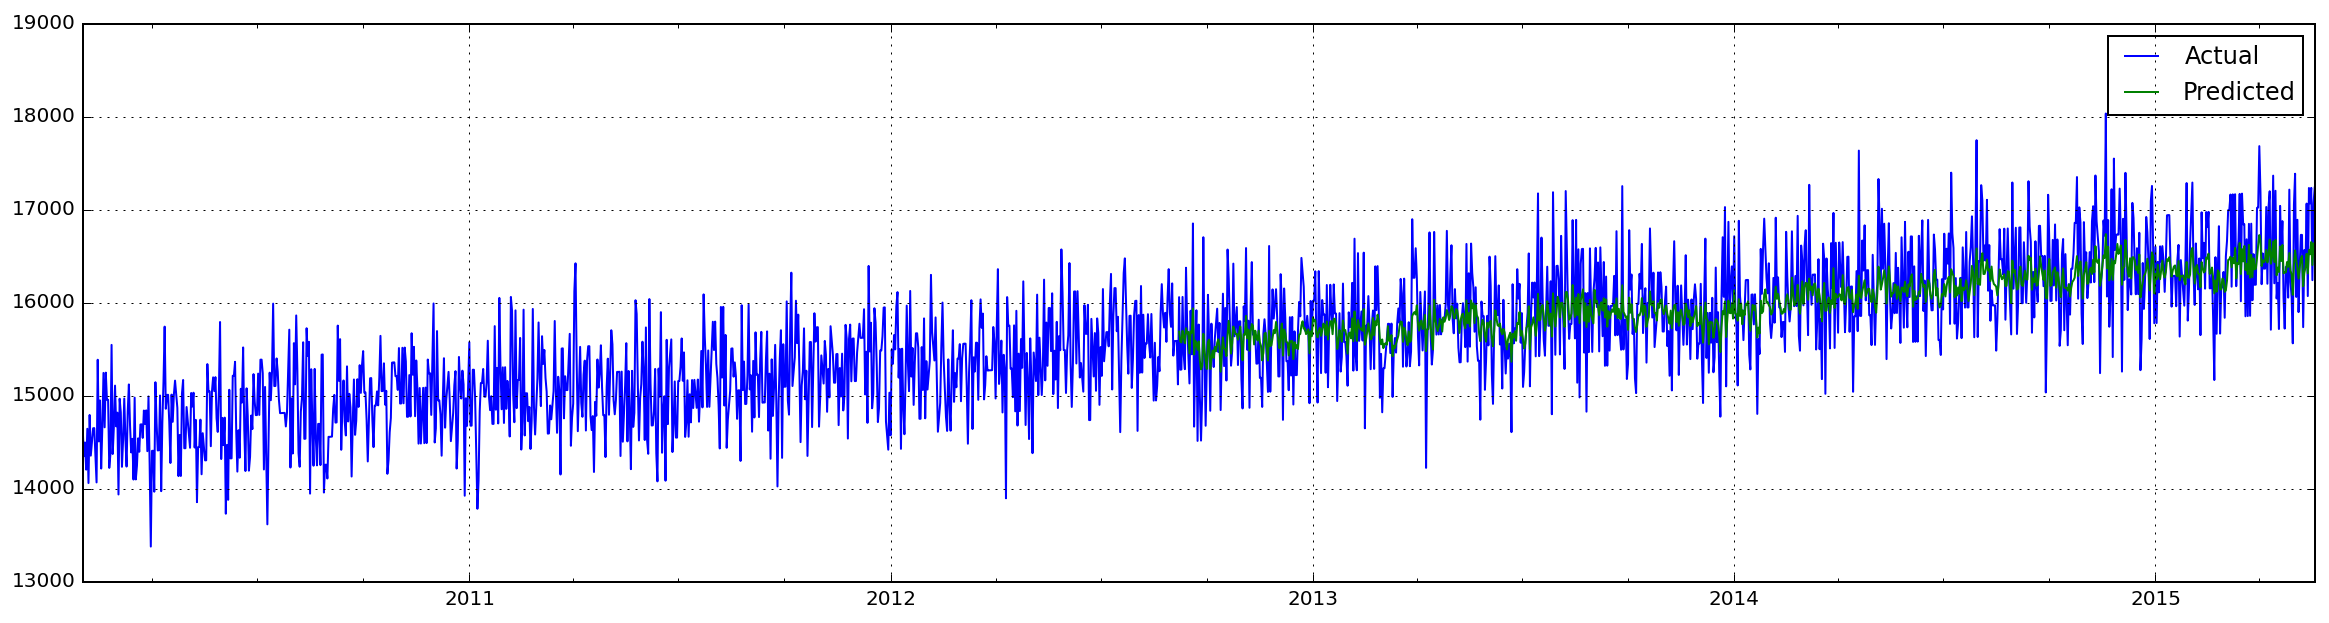

In [195]:
results = []
from sklearn import cross_validation, feature_selection, linear_model
import datetime
for company in companies[:1]:
    sd = datetime.datetime(2010, 1, 1)
    ed = datetime.datetime(2015, 5, 15)
    d1 = df_[sd:ed]
    X, y = prepare_df(
            d1, 
            input_cols=['%s_Lag1' % company, '%s_EWMA_7' % company, '%s_RollSum_15' % company],
            output_col='%s_Direction' % company
        )
    data1 = split_for_train(X, y, sd, ed) 
    dir_model = try_models(*data1, fs=feature_selection.RFECV(linear_model.LogisticRegression()), draw=False)
    predicted_dir = dir_model['FSEstimator'][0].predict(X)
    X['%s_Estimated_Direction' % company] = predicted_dir
    results.append(dir_model)
    ####
    data2 =  split_for_train(*list(prepare_df(
                d1,
                input_cols=get_independent_values(company, X) + get_independent_values('Total', X),
                output_col=company,
                drop_cols=['%s_Direction' % company, 'Total_Direction', 'Total']
            )) + [sd, ed])
    results.append(try_models(*data2,
                   fs=feature_selection.RFECV(linear_model.Ridge(alpha=10), 1)))
    
final = pd.concat(results, ignore_index=True)
from IPython.display import HTML
# final.drop('FSEstimator', axis=1).drop('Vars', axis=1)


### Conclusion
As we have seen from the examples and charts above, the price of a company as an upward trend with 10% randomness along its moving average mean.

In order to create a suggestion model for buy/sell indicators, we can fit our data in *mean-reversion model*. The price fluctuates around it's moving average , but it never goes beyond a certain limit.

Thus, we can rules for our model as follows (significance factor used in this model is `0.015`):
- If the current price is significantly higher than its moving average, suggest *SELL*
- If the current price is significantly lower than its moving average, suggest *BUY*
- If the current price is insignificant / close its moving average, suggest *WAIT*.

Using this model, we can safely and confidently indicate BUY/SELL/WAIT for any company in the market.